In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install stellargraph
import stellargraph as sg

!pip install networkx
import networkx as nx

!pip install scikit-plot

import sys
sys.path.append('/content/drive/MyDrive')

from inductiveGRL.graphconstruction import GraphConstruction

In [100]:
### Set the number of nodes to subset for visualisation

train_nodes_n = 900
test_nodes_n = 303

In [101]:
data_full = pd.read_csv('/content/drive/MyDrive/AI Dissertation /data/bs140513_032310.csv')
data_full["index"] = data_full.index
# add a column to data for customer id and merchant id with prefix 1: C and 2: M
data_full['merchant_id'] = data_full['merchant'].str.replace("M", '2').str.replace("'", "")
data_full['customer_id'] = data_full['customer'].str.replace("C", '1').str.replace("'", "")
data_full['category'] = data_full['category'].str.replace("'", "")
data_full['age'] = data_full['age'].str.replace("'", "")

category_oh = pd.get_dummies(data_full['category'], prefix='category')
data_full = data_full.join(category_oh)

age_oh = pd.get_dummies(data_full['age'], prefix='age')
data_full = data_full.join(age_oh)

def split_data(data, split_start, split_end):
    return data.loc[(data['step'] >= split_start) & (data['step'] <= split_end)]

data_train = split_data(data_full, 0, 0)
data_test = split_data(data_full, 1, 1)

def get_merchant(data, merchant_id):
  return data.loc[(data['merchant_id'] == merchant_id)]

data_train_m = get_merchant(data=data_train, merchant_id='2348934600')
data_test_m = get_merchant(data=data_train, merchant_id='2348934600')


In [102]:
def data_to_graph(dataset):
  ### nodes
  #node_customers = pd.DataFrame([1]*len(dataset.customer_id.unique())).set_index(dataset.customer_id.unique())
  node_customers = dataset[["customer_id", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U"]].drop_duplicates(subset=["customer_id"]).set_index("customer_id")
  #print(node_customers.loc["1369566106"])
  node_merchants = pd.DataFrame([1]*len(dataset.merchant_id.unique())).set_index(dataset.merchant_id.unique())

  # transaction node data
  node_txns = dataset[["amount", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", 
                       "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", 
                       "category_es_travel", "category_es_wellnessandbeauty", "index"]]

  ### edges
  # customer to transaction edges
  edge_customer = dataset[["customer_id", "index"]]

  # transaction to merchant edges
  edge_merchant = dataset[["index", "merchant_id"]]

  nodes = {"customer":dataset.customer_id, "merchant":dataset.merchant_id, "transaction":dataset.index}
  edges = [zip(edge_customer.customer_id, edge_customer.index),zip(edge_merchant.index, edge_merchant.merchant_id)]
  features = {"transaction": node_txns, 'customer': node_customers, 'merchant': node_merchants}

  graph = GraphConstruction(nodes, edges, features)
  S = graph.get_stellargraph()
  return S, edges

#print(inductive_graph_data)


StellarGraph: Undirected multigraph
 Nodes: 1830, Edges: 1800

 Node types:
  transaction: [900]
    Features: float32 vector, length 12
    Edge types: transaction-default->customer, transaction-default->merchant
  customer: [899]
    Features: float32 vector, length 8
    Edge types: customer-default->transaction
  merchant: [31]
    Features: float32 vector, length 1
    Edge types: merchant-default->transaction

 Edge types:
    merchant-default->transaction: [900]
        Weights: all 1 (default)
        Features: none
    customer-default->transaction: [900]
        Weights: all 1 (default)
        Features: none


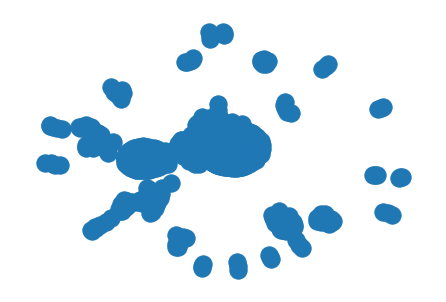

In [103]:
S_train, e_train = data_to_graph(data_train.head(train_nodes_n))
print(S_train.info())
nx_train = S_train.to_networkx()
nx.draw(nx_train, with_labels=False, font_weight='bold')

StellarGraph: Undirected multigraph
 Nodes: 2344, Edges: 2406

 Node types:
  transaction: [1203]
    Features: float32 vector, length 12
    Edge types: transaction-default->customer, transaction-default->merchant
  customer: [1106]
    Features: float32 vector, length 8
    Edge types: customer-default->transaction
  merchant: [35]
    Features: float32 vector, length 1
    Edge types: merchant-default->transaction

 Edge types:
    merchant-default->transaction: [1203]
        Weights: all 1 (default)
        Features: none
    customer-default->transaction: [1203]
        Weights: all 1 (default)
        Features: none


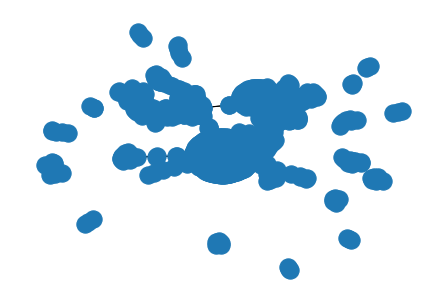

In [104]:
pd.options.mode.chained_assignment = None

inductive_graph_data = pd.concat((data_train.head(train_nodes_n), data_test.head(test_nodes_n)))

S_ind, e_ind = data_to_graph(inductive_graph_data)
print(S_ind.info())
nx_ind = S_ind.to_networkx()
nx.draw(nx_ind, with_labels=False, font_weight='bold')
